## Convolution Neural Networks

In [2]:
import os
import numpy as np
import torch
import cv2
from tqdm import tqdm

Rebuild_Data = False

In [3]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm

class DogsVSCats:
    IMG_SIZE = (50, 50)
    CATS = "../PetImages/Cat"
    DOGS = "../PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}

    def __init__(self):
        self.training_data = []
        self.catcount = 0
        self.dogcount = 0
        self.hg_data = []

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                path = os.path.join(label, f)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                one_hot_label = np.eye(2)[self.LABELS[label]]
               

                if img is not None:
                    try:
                        img = cv2.resize(img, self.IMG_SIZE)
                    except Exception as e:
                        print(f"Failed to process {f}: {e}")
                        continue  # Skip this image if an error occurs
                    self.training_data.append(np.array([np.array(img), one_hot_label],dtype="object"))
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1

        for data in tqdm(self.training_data):
            if (len(data) == 2 and isinstance(data[0], np.ndarray) and data[0].shape == self.IMG_SIZE and isinstance(data[1], np.ndarray) and data[1].shape == (2,)):
                self.hg_data.append(data)
            else:
                print(f"Skipping inhomogeneous element: {data}")

        # Save the homogeneous data with allow_pickle=True
        np.save("../training_data.npy",self.hg_data, allow_pickle=True)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)

# Example usage
Rebuild_Data = False
if Rebuild_Data:
    dataset = DogsVSCats()
    dataset.make_training_data()

In [5]:
training_data = np.load("../training_data.npy",allow_pickle=True)

In [6]:
print(len(training_data))

24946


In [7]:
print(training_data[1])

[array([[ 44,  60,  41, ...,  95,  94, 197],
        [ 41,  43,  43, ...,  93,  80, 192],
        [ 41,  40,  46, ...,  90,  86, 193],
        ...,
        [ 25,  21,  26, ...,  43,  67,  73],
        [ 21,  23,  21, ...,  74,  36,  89],
        [ 23,  22,  20, ...,  59,  62,  32]], dtype=uint8) array([1., 0.])]


<function matplotlib.pyplot.show(close=None, block=None)>

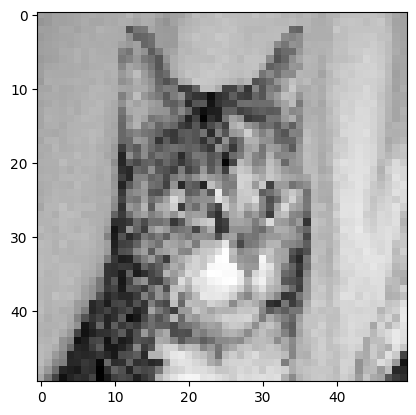

In [8]:
import matplotlib.pyplot as plt

plt.imshow(training_data[11][0],cmap="gray")
plt.show

## Model Creation

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)  # 5x5 kernel, 1 input channel, 32 output channels
        self.conv2 = nn.Conv2d(32, 64, 5, 1) # 5x5 kernel, 32 input channels, 64 output channels
        self.conv3 = nn.Conv2d(64, 128, 5, 1) # 5x5 kernel, 64 input channels, 128 output channels
        # Calculate the flattened size after conv and pooling layers.
        self.fc1 = nn.Linear(128 * 2 * 2, 16)  # Update the input size accordingly
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        print("Input shape:", x.shape)
        x = F.relu(self.conv1(x))
        print("After conv1:", x.shape)
        x = F.max_pool2d(x, 2, 2)
        print("After pool1:", x.shape)
        x = F.relu(self.conv2(x))
        print("After conv2:", x.shape)
        x = F.max_pool2d(x, 2, 2)
        print("After pool2:", x.shape)
        x = F.relu(self.conv3(x))
        print("After conv3:", x.shape)
        x = F.max_pool2d(x, 2, 2)
        print("After pool3:", x.shape)
        x = x.view(-1, 128 * 2 * 2)  # Flatten the tensor
        print("After flatten:", x.shape)
        x = F.relu(self.fc1(x))
        print("After fc1:", x.shape)
        x = self.fc2(x)
        print("After fc2:", x.shape)
        return x

# Example usage
net = Net()

# Create a dummy input tensor with shape (batch_size, channels, height, width)
dummy_input = torch.randn(1, 1, 50, 50)  # Batch size of 1, 1 channel, 50x50 image

output = net.forward(dummy_input)
print("Output:", output)


Input shape: torch.Size([1, 1, 50, 50])
After conv1: torch.Size([1, 32, 46, 46])
After pool1: torch.Size([1, 32, 23, 23])
After conv2: torch.Size([1, 64, 19, 19])
After pool2: torch.Size([1, 64, 9, 9])
After conv3: torch.Size([1, 128, 5, 5])
After pool3: torch.Size([1, 128, 2, 2])
After flatten: torch.Size([1, 512])
After fc1: torch.Size([1, 16])
After fc2: torch.Size([1, 2])
Output: tensor([[0.1466, 0.0320]], grad_fn=<AddmmBackward0>)


#
#
# Hidden Layers

**Role:**
- The hidden layers transform the input data into a space where the patterns relevant to the problem can be more easily separated.
- These layers create complex, non-linear mappings of the input data.

## **Common Activation Functions:**
## $ \text{ReLU}(x) = \max(0, x) $
  - Pros: Helps with the vanishing gradient problem, computationally efficient.
  - Cons: Can suffer from the "dying ReLU" problem where neurons can get stuck during training.
## $ \text{Sigmoid}(x) = \frac{1}{1 + e^{-x}} $
  - Pros: Outputs values between 0 and 1, can be interpreted as probabilities.
  - Cons: Can cause vanishing gradient problems.
## $ \text{Tanh}(x) =  \frac{e^x - e^{-x}}{e^x + e^{-x}} $
  - Pros: Outputs values between -1 and 1, zero-centered.
  - Cons: Also suffers from vanishing gradient issues.

# Output Layers

**Role:**
- The output layer produces the final result of the neural network, which could be a classification, a regression value, etc.
- Different problems require different output ranges and interpretations.

# **Common Activation Functions for Output Layers:**
## **Softmax:** Typically used in multi-class classification problems.
> ## $ \text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}} $
  - Pros: Converts logits into probabilities that sum to 1.
  - Cons: Not suitable for regression tasks.
## **Sigmoid:** Often used in binary classification problems.
> ## $ \text{Sigmoid}(x) = \frac{1}{1 + e^{-x}} $
  - Pros: Outputs values between 0 and 1.
  - Cons: Limited to binary outcomes.
## **Linear:** Used in regression problems.
> ## $ \text{Linear}(x) = x $
  - Pros: Suitable for predicting continuous values.
  - Cons: Not suitable for classification tasks.

# Why Not Use ReLU in the Output Layer?

**ReLU Characteristics:**
- Outputs any positive value as itself and zero for any negative input.
- Not bounded, meaning its output range is $[0, \infty)$.

**Example:**

1. **Classification Problem:**
   - If you use ReLU in the output layer for a classification problem (e.g., a multi-class classification task), you would get non-negative outputs but not probabilities. Classification typically requires interpreting the output as probabilities, which should sum to 1. ReLU cannot naturally enforce this constraint, unlike the Softmax function.

2. **Regression Problem:**
   - For regression tasks, using ReLU could limit the range of the output to non-negative values only. This might not be desirable if the target values can be negative. For example, predicting house prices could work with ReLU if prices are always positive, but predicting temperature, which can be negative, would be inappropriate with ReLU.

### Detailed Example: Multi-Class Classification

Consider a neural network designed to classify images into one of three categories: Cat, Dog, and Bird. The final layer must output a probability distribution over these three classes.

**Using ReLU in the Output Layer:**
- The network might output values like [2.5, 0, 3.7] for an input image.
- These values are not probabilities and do not sum to 1.
- There's no straightforward way to interpret these values as the likelihood of each class.

**Using Softmax in the Output Layer:**
- The network might output logits [2.5, 0, 3.7].
- After applying Softmax, these logits might convert to probabilities like [0.28, 0.01, 0.71].
- These probabilities sum to 1, making it clear that the model predicts "Bird" with 71% confidence.

### Conclusion

The choice of activation function in the output layer is crucial and must align with the problem requirements. While ReLU is excellent for hidden layers due to its properties that help mitigate issues like the vanishing gradient problem, it is not suitable for output layers in many cases because it does not provide a bounded, interpretable output suitable for classification or regression tasks. Different tasks necessitate different activation functions to ensure the outputs are meaningful and useful for the specific application.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)  # 5x5 kernel, 1 input channel, 32 output channels
        self.conv2 = nn.Conv2d(32, 64, 5, 1) # 5x5 kernel, 32 input channels, 64 output channels
        self.conv3 = nn.Conv2d(64, 128, 5, 1) # 5x5 kernel, 64 input channels, 128 output channels
        # Calculate the flattened size after conv and pooling layers.
        self.fc1 = nn.Linear(128 * 2 * 2, 16)  # Update the input size accordingly
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 128 * 2 * 2)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=1)

# Example usage
net = Net()


net = Net()
print(net)
# Create a dummy input tensor with shape (batch_size, channels, height, width)
dummy_input = torch.randn(1, 1, 50, 50)  # Batch size of 1, 1 channel, 50x50 image

output = net.forward(dummy_input)
print("Output:", output)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)
Output: tensor([[0.4510, 0.5490]], grad_fn=<SoftmaxBackward0>)


In [11]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(),0.0001)
loss_function = nn.MSELoss()


C:\Users\opdar\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\opdar\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [12]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

C:\Users\opdar\AppData\Local\Temp\ipykernel_13464\3353633519.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)


In [13]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [14]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=val_size, random_state=42)

# train_X and train_y will contain data for training
# test_X and test_y will contain data for testing


The main difference between `model.zero_grads()` and `optimizer.zero_grads()` lies in the scope of the operation:

- `model.zero_grads()`: This method zeroes the gradients of all parameters in the model. It directly operates on the model itself, making it suitable for cases where you want to manually manage the gradient clearing process within the model.

- `optimizer.zero_grads()`: On the other hand, this method zeroes the gradients of only the parameters that the optimizer is responsible for updating. It operates on the optimizer object and is commonly used during the training loop after the backward pass to clear gradients before the optimizer updates the model parametmized.

In [15]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]
        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        if i%10000==0:
            print(batch_X)
            print(outputs,batch_y)
            print(f"Epoch: {epoch}. Loss: {loss}")
        loss.backward()
        optimizer.step()    # Does the update


  0%|                                              | 0/225 [00:00<?, ?it/s]

tensor([[[[0.6275, 0.5882, 0.6275,  ..., 0.4078, 0.4118, 0.3765],
          [0.6784, 0.6118, 0.6078,  ..., 0.3765, 0.3020, 0.2824],
          [0.6824, 0.6588, 0.6196,  ..., 0.2471, 0.2980, 0.3647],
          ...,
          [0.9647, 0.9451, 0.9451,  ..., 0.7725, 0.7686, 0.7255],
          [0.9529, 0.9373, 0.9373,  ..., 0.8235, 0.7686, 0.7294],
          [0.9765, 0.9765, 0.9686,  ..., 0.8431, 0.9176, 0.7765]]],


        [[[1.0000, 1.0000, 0.9922,  ..., 0.5255, 0.5529, 0.4980],
          [0.9961, 0.9922, 0.9882,  ..., 0.3765, 0.5765, 0.5529],
          [0.9922, 0.9961, 0.9961,  ..., 0.6314, 0.6196, 0.5255],
          ...,
          [0.4000, 0.5765, 0.5569,  ..., 0.7804, 0.7882, 0.7961],
          [0.4510, 0.5765, 0.4902,  ..., 0.7412, 0.7333, 0.7569],
          [0.4627, 0.5412, 0.4000,  ..., 0.7529, 0.7176, 0.4627]]],


        [[[0.0275, 0.0353, 0.0314,  ..., 0.5922, 0.3804, 0.2000],
          [0.0314, 0.0314, 0.0392,  ..., 0.6118, 0.4784, 0.2275],
          [0.0353, 0.0353, 0.0353,  ..

 45%|████████████████▏                   | 101/225 [00:18<00:20,  6.15it/s]

tensor([[[[0.0980, 0.0980, 0.0667,  ..., 0.2510, 0.1843, 0.1922],
          [0.1373, 0.1333, 0.0941,  ..., 0.2667, 0.1647, 0.1608],
          [0.1529, 0.1216, 0.1333,  ..., 0.1961, 0.2000, 0.1882],
          ...,
          [0.2980, 0.2902, 0.1961,  ..., 0.2588, 0.2196, 0.3098],
          [0.0863, 0.1098, 0.1255,  ..., 0.2706, 0.2392, 0.2078],
          [0.2471, 0.2510, 0.1412,  ..., 0.3098, 0.3686, 0.2784]]],


        [[[0.5961, 0.8000, 0.6941,  ..., 0.7176, 0.9176, 0.9137],
          [0.5529, 0.8784, 0.7412,  ..., 0.6627, 0.9216, 0.9176],
          [0.5216, 0.9216, 0.7451,  ..., 0.9176, 0.9137, 0.9176],
          ...,
          [0.7569, 0.8078, 0.8275,  ..., 0.7725, 0.8588, 0.8588],
          [0.8471, 0.8431, 0.8235,  ..., 0.8196, 0.7961, 0.7725],
          [0.8353, 0.8235, 0.8471,  ..., 0.8706, 0.8824, 0.8353]]],


        [[[0.4431, 0.4510, 0.4627,  ..., 0.5882, 0.5137, 0.4941],
          [0.3882, 0.4588, 0.4745,  ..., 0.6196, 0.5255, 0.5098],
          [0.1608, 0.4667, 0.4824,  ..

 89%|████████████████████████████████▏   | 201/225 [00:34<00:03,  6.08it/s]

tensor([[[[0.2000, 0.2627, 0.3804,  ..., 0.4510, 0.4471, 0.4549],
          [0.2078, 0.2588, 0.3804,  ..., 0.4510, 0.4510, 0.4588],
          [0.2118, 0.2627, 0.3765,  ..., 0.4549, 0.4549, 0.4549],
          ...,
          [0.4314, 0.4706, 0.4980,  ..., 0.3373, 0.3490, 0.3333],
          [0.4824, 0.4902, 0.4549,  ..., 0.3255, 0.3451, 0.3294],
          [0.4196, 0.4588, 0.4392,  ..., 0.3412, 0.3373, 0.3333]]],


        [[[0.4275, 0.4392, 0.4941,  ..., 0.0275, 0.0431, 0.0353],
          [0.4667, 0.4745, 0.4078,  ..., 0.0667, 0.0745, 0.0784],
          [0.4314, 0.3608, 0.3686,  ..., 0.1686, 0.2392, 0.1490],
          ...,
          [0.2863, 0.3765, 0.4275,  ..., 0.0863, 0.0706, 0.1294],
          [0.2824, 0.3333, 0.4235,  ..., 0.0784, 0.0667, 0.1059],
          [0.2471, 0.3020, 0.3176,  ..., 0.0667, 0.0549, 0.0824]]],


        [[[0.9333, 0.9216, 0.7647,  ..., 0.4118, 0.2392, 0.5137],
          [0.9020, 0.8980, 0.7176,  ..., 0.3608, 0.2980, 0.4078],
          [0.9216, 0.8863, 0.9176,  ..

100%|████████████████████████████████████| 225/225 [00:38<00:00,  5.82it/s]


In [16]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|█████████████████████████████████| 2494/2494 [00:04<00:00, 611.80it/s]

Accuracy:  0.622


## Training On GPU

In [73]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [74]:
torch.cuda.device_count()

1

In [75]:
net = Net()

In [76]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)

In [77]:
%%time
optimizer = optim.Adam(net.parameters(),0.0003)
loss_function = nn.MSELoss().to(device)
Epochs = 40
BATCH_SIZE = 100
def train(net):
    for epoch in range(Epochs):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
            #print(f"{i}:{i+BATCH_SIZE}")
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
            batch_y = train_y[i:i+BATCH_SIZE].to(device)
            net.zero_grad()
            
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step() 
        print(f"Epoch: {epoch}. Loss: {loss}")

train(net)

100%|████████████████████████████████████| 225/225 [00:02<00:00, 81.32it/s]


Epoch: 0. Loss: 0.2358788102865219


100%|████████████████████████████████████| 225/225 [00:02<00:00, 88.13it/s]


Epoch: 1. Loss: 0.19341233372688293


100%|████████████████████████████████████| 225/225 [00:02<00:00, 88.18it/s]


Epoch: 2. Loss: 0.14679287374019623


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.78it/s]


Epoch: 3. Loss: 0.12288574874401093


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.74it/s]


Epoch: 4. Loss: 0.10470270365476608


100%|████████████████████████████████████| 225/225 [00:02<00:00, 88.14it/s]


Epoch: 5. Loss: 0.09223631769418716


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.81it/s]


Epoch: 6. Loss: 0.08314571529626846


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.75it/s]


Epoch: 7. Loss: 0.07610497623682022


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.07it/s]


Epoch: 8. Loss: 0.07063352316617966


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.68it/s]


Epoch: 9. Loss: 0.06532035768032074


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.64it/s]


Epoch: 10. Loss: 0.05949827656149864


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.90it/s]


Epoch: 11. Loss: 0.0542074553668499


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.64it/s]


Epoch: 12. Loss: 0.05047612637281418


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.61it/s]


Epoch: 13. Loss: 0.04632323235273361


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.30it/s]


Epoch: 14. Loss: 0.042012590914964676


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.81it/s]


Epoch: 15. Loss: 0.037352632731199265


100%|████████████████████████████████████| 225/225 [00:02<00:00, 88.01it/s]


Epoch: 16. Loss: 0.03495047613978386


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.92it/s]


Epoch: 17. Loss: 0.0328926257789135


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.70it/s]


Epoch: 18. Loss: 0.022412855178117752


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.93it/s]


Epoch: 19. Loss: 0.017423516139388084


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.55it/s]


Epoch: 20. Loss: 0.01435967069119215


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.46it/s]


Epoch: 21. Loss: 0.014455851167440414


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.90it/s]


Epoch: 22. Loss: 0.02061457745730877


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.98it/s]


Epoch: 23. Loss: 0.0248182974755764


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.91it/s]


Epoch: 24. Loss: 0.006939131300896406


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.71it/s]


Epoch: 25. Loss: 0.007720933761447668


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.68it/s]


Epoch: 26. Loss: 0.007109211292117834


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.73it/s]


Epoch: 27. Loss: 0.007647277321666479


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.66it/s]


Epoch: 28. Loss: 0.012831190600991249


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.66it/s]


Epoch: 29. Loss: 0.02658802829682827


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.27it/s]


Epoch: 30. Loss: 0.02672279067337513


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.78it/s]


Epoch: 31. Loss: 0.019203132018446922


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.83it/s]


Epoch: 32. Loss: 0.03838939219713211


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.80it/s]


Epoch: 33. Loss: 0.0170846376568079


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.44it/s]


Epoch: 34. Loss: 0.009216934442520142


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.49it/s]


Epoch: 35. Loss: 0.0032603817526251078


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.58it/s]


Epoch: 36. Loss: 0.002317760605365038


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.87it/s]


Epoch: 37. Loss: 0.0031479408498853445


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.65it/s]


Epoch: 38. Loss: 0.0024934441316872835


100%|████████████████████████████████████| 225/225 [00:02<00:00, 87.28it/s]

Epoch: 39. Loss: 0.002891820389777422
CPU times: total: 8.89 s
Wall time: 1min 42s


In [78]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)
    
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy: ", round(correct/total, 3))
test(net)

100%|█████████████████████████████████| 2494/2494 [00:03<00:00, 745.44it/s]

Accuracy:  0.768


## Model Analysis